## Chips

In [3]:
############
# Is the data uniformly distributed over the STN?
############
#
# To test this question we devide the STN into 27 sectors based on a PCA analysis where we identify the three main 
#   axes which are then each devided into three parts. 
#
# The mean intensity per stain is subtracted of each elipsoid, so that if the data is uniformly distributed each
#   sector would be equal to zero. If there are sectors that have a signal lower than the overall mean these sectors
#   will have a negative value and vice versa for higher signals. 
# 

# Importing a number of different tools
from sklearn.decomposition import PCA
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
sns.set_style('whitegrid')
import pandas
from pystain import StainDataset

# Start code
subject_id = 13095
ds = StainDataset(subject_id)

conversion_matrix = np.array([[0, 0, ds.xy_resolution],
                              [-ds.z_resolution, 0, 0],
                              [0, -ds.xy_resolution, 0]])
results = []

# What are the subject IDs?
subject_ids=[13095, 14037, 14051, 14069, 15033, 15035, 15055]

# What fwhm to use here?
fwhms = [0.3, 0.6, 1.2, 2.4]
for fwhm in fwhms:
    for subject_id in subject_ids[:]:
        ds = StainDataset(subject_id, fwhm=fwhm)

    # Get coordinates of mask and bring them to mm
        x, y, z = np.where(ds.thresholded_mask)
        coords = np.column_stack((x, y, z))
        coords_mm = conversion_matrix.dot(coords.T).T
        coords_mm -= coords_mm.mean(0)

    # Fit two components and make sure first axis walks dorsal
    #   and second component lateral
        pca = PCA()
        pca.fit_transform((coords_mm - coords_mm.mean(0))[:, (0, 2)])

        components = pca.components_
        print components

        if components[0, 1] < 0:
            components[0] = -components[0]

        if components[1, 0] < 0:
            components[1] = -components[1]

        print components

        coords_dataframe = pandas.DataFrame(coords_mm, columns=['x_mm', 'y_mm', 'z_mm'])
        coords_dataframe['slice'] = x

        coords_dataframe['pc1'] = components.dot(coords_mm[:, (0, 2)].T)[0, :]
        coords_dataframe['pc2'] = components.dot(coords_mm[:, (0, 2)].T)[1, :]

        coords_dataframe[['pc1_slice_center', 'pc2_slice_center']] = coords_dataframe.groupby(['slice'])[['pc1', 'pc2']].apply(lambda x: x - x.mean())

        coords_dataframe['slice_3'] = pandas.qcut(coords_dataframe.y_mm, 3, labels=['posterior', 'middle', 'anterior'])    

        coords_dataframe['pc1_3'] = coords_dataframe.groupby('slice_3').pc1.apply(lambda d: pandas.qcut(d, 3, labels=['ventral', 'middle', 'dorsal']))
        coords_dataframe['pc2_3'] = coords_dataframe.groupby(['slice_3', 'pc1_3']).pc2.apply(lambda d: pandas.qcut(d, 3, labels=['medial', 'middle', 'lateral']))

        df= pandas.concat((ds.smoothed_dataframe, coords_dataframe), 1)
        tmp = df.pivot_table(index=['pc1_3', 'pc2_3', 'slice_3'], values=ds.stains, aggfunc='mean').copy()
        tmp['subject_id'] = subject_id
        tmp['fwhm'] = fwhm

        results.append(tmp.copy())

df = pandas.concat(results).reset_index().set_index(['subject_id', 'slice_3', 'pc1_3', 'pc2_3'])
df = pandas.melt(df.reset_index(), id_vars=['fwhm', 'subject_id', 'slice_3', 'pc1_3', 'pc2_3'], var_name='stain')
df['value'] = df.groupby(['fwhm', 'subject_id', 'stain']).transform(lambda x: (x - x.mean()) / x.std())

/home/mkeuken1/data/post_mortem/new_data_format/13095/images.hdf5
/home/mkeuken1/data/post_mortem/new_data_format/13095/images.hdf5
[[-0.98094749 -0.19427308]
 [-0.19427308  0.98094749]]
[[ 0.98094749  0.19427308]
 [ 0.19427308 -0.98094749]]
/home/mkeuken1/data/post_mortem/new_data_format/14037/images.hdf5
[[-0.95611755 -0.29298334]
 [ 0.29298334 -0.95611755]]
[[ 0.95611755  0.29298334]
 [ 0.29298334 -0.95611755]]
/home/mkeuken1/data/post_mortem/new_data_format/14051/images.hdf5
[[-0.78933812 -0.61395874]
 [ 0.61395874 -0.78933812]]
[[ 0.78933812  0.61395874]
 [ 0.61395874 -0.78933812]]
/home/mkeuken1/data/post_mortem/new_data_format/14069/images.hdf5
[[-0.70764237 -0.70657079]
 [ 0.70657079 -0.70764237]]
[[ 0.70764237  0.70657079]
 [ 0.70657079 -0.70764237]]
/home/mkeuken1/data/post_mortem/new_data_format/15033/images.hdf5
[[-0.66358108 -0.74810437]
 [ 0.74810437 -0.66358108]]
[[ 0.66358108  0.74810437]
 [ 0.74810437 -0.66358108]]
/home/mkeuken1/data/post_mortem/new_data_format/15035/

In [ ]:
# # Importing a number of different tools
# from statsmodels.sandbox.stats import multicomp
# from matplotlib import patches
# import scipy as sp
# sns.set_style('white')
# df.stain.unique()
# %matplotlib inline

# # gray 'background' of STN instead of white
# cmap = matplotlib.colors.LinearSegmentedColormap.from_list('colormap', ['blue', 'gray', 'red'])
# def plot_ellipse_values(values, ellipse_pars=None, size=(1000, 1000), vmin=None, vmax=None, cmap=plt.cm.coolwarm, **kwargs):

#     ''' values is a n-by-m array'''

#     values[np.isnan(values)] = 0
#     if ellipse_pars is None:
#         a = 350
#         b = 150
#         x = 500
#         y = 500

#         theta = 45. / 180 * np.pi

#     else:
#         a, b, x, y, theta = ellipse_pars

#     A = a**2 * (np.sin(theta))**2 + b**2 * (np.cos(theta))**2
#     B = 2 * (b**2 - a**2) * np.sin(theta) * np.cos(theta)
#     C = a**2 * np.cos(theta)**2 + b**2 * np.sin(theta)**2
#     D = -2 * A * x - B* y
#     E = -B * x - 2 * C * y
#     F = A* x**2 + B*x*y + C*y**2 - a**2*b**2

#     X,Y = np.meshgrid(np.arange(size[0]), np.arange(size[1]))

#     in_ellipse = A*X**2 + B*X*Y +C*Y**2 + D*X + E*Y +F < 0

#     pc1 = np.array([[np.cos(theta)], [np.sin(theta)]])
#     pc2 = np.array([[np.cos(theta - np.pi/2.)], [np.sin(theta - np.pi/2.)]])

#     pc1_distance = pc1.T.dot(np.array([(X - x).ravel(), (Y - y).ravel()])).reshape(X.shape)
#     pc2_distance = pc2.T.dot(np.array([(X - x).ravel(), (Y - y).ravel()])).reshape(X.shape)

#     pc1_quantile = np.floor((pc1_distance / a + 1 ) / 2. * values.shape[0])
#     pc2_quantile = np.floor((pc2_distance / b + 1 ) / 2. * values.shape[1])

#     im = np.zeros_like(X, dtype=float)

#     for pc1_q in np.arange(values.shape[0]):
#         for pc2_q in np.arange(values.shape[1]):
#             im[in_ellipse * (pc1_quantile == pc1_q) & (pc2_quantile == pc2_q)] = values[pc1_q, pc2_q]

#     im = np.ma.masked_array(im, ~in_ellipse)
# #     cmap.set_bad('grey')
#     cax = plt.imshow(im, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax, **kwargs)
#     sns.despine()

#     return cax

# fwhms = [0.3, 0.6, 1.2, 2.4]
# for fwhm in fwhms:
#     # What is the output folder for the PCA figures:
#     pca_folder = '/home/mkeuken1/data/post_mortem/visualize_stains_v2/PCA_sectors/fwhm_%s' %fwhm
#     if not os.path.exists(pca_folder):
#         os.makedirs(pca_folder) 

#     # For every stain and sector over the 7 subjects plot the data and test whether it differs from zero:
#     for stain, d in df.loc[df.fwhm==fwhm].groupby(['stain']):
#         fn = '/home/mkeuken1/data/post_mortem/visualize_stains_v2/PCA_sectors/fwhm_%s/%s_big_picture_coolwarm.pdf' %(fwhm, stain)
#         pdf = PdfPages(fn)

#         fig, axes = plt.subplots(nrows=1, ncols=3)

#         for i, (slice, d2) in enumerate(d.groupby('slice_3')):

#             ax = plt.subplot(1, 3, ['anterior', 'middle', 'posterior'].index(slice) + 1)

#             n = d2.groupby(['pc1_3', 'pc2_3']).value.apply(lambda v: len(v)).unstack(1).ix[['ventral', 'middle', 'dorsal'], ['medial', 'middle', 'lateral']]
#             t = d2.groupby(['pc1_3', 'pc2_3']).value.apply(lambda v: sp.stats.ttest_1samp(v, 0,nan_policy='omit')[0]).unstack(1).ix[['ventral', 'middle', 'dorsal'], ['medial', 'middle', 'lateral']]
#             p = d2.groupby(['pc1_3', 'pc2_3']).value.apply(lambda v: sp.stats.ttest_1samp(v, 0,nan_policy='omit')[1]).unstack(1).ix[['ventral', 'middle', 'dorsal'], ['medial', 'middle', 'lateral']]
#             mean = d2.groupby(['pc1_3', 'pc2_3']).value.mean().unstack(1).ix[['ventral', 'middle', 'dorsal'], ['medial', 'middle', 'lateral']]

#             # FDR: as we are doing 27 seperate t-tests we need to correct for multiple comparisons:
#             p.values[:] = multicomp.fdrcorrection0(p.values.ravel())[1].reshape(3, 3)

#             # Providing some parameters for plotting the figures
#             if i == 1:
#                 a, b, x, y, theta  = 350, 150, 300, 275, 45
#             else:
#                 a, b, x, y, theta  = 300, 125, 300, 275, 45.

#             plot_ellipse_values(t[p<0.05].values, size=(600, 550), ellipse_pars=(a, b, x, y,  theta / 180. * np.pi), vmin=-7, vmax=7, cmap=cmap2)#plt.cm.coolwarm)

#             e1 = patches.Ellipse((x, y), a*2, b*2,
#                              angle=theta, linewidth=2, fill=False, zorder=2)

#             ax.add_patch(e1)

#             plt.xticks([])
#             plt.yticks([]) 

#             sns.despine(bottom=True, left=True)

#             print stain
#             print p.values
#         plt.suptitle(stain, fontsize=24)
#         fig.set_size_inches(15., 4.)
#         pdf.savefig(fig, transparent=True)    
#         pdf.close()


(0.0, 0)


/opt/anaconda/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:83: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


CALR
[[  5.34068634e-04   2.50732216e-04   1.86304348e-04]
 [  5.26880268e-02   2.27548328e-02   1.09905774e-03]
 [  2.61606877e-01   2.66856031e-01   2.57288596e-01]]
(0.0, 1)
CALR
[[  2.40918794e-01   1.67301334e-01   7.81614479e-02]
 [  2.26324607e-03   1.84200296e-03   6.96200095e-01]
 [  1.07619416e-04   1.37581657e-03   1.24354205e-01]]
(0.0, 2)
CALR
[[  5.65716880e-01   1.77379063e-02   1.17241325e-01]
 [  1.69706272e-04   1.69706272e-04   1.69706272e-04]
 [  2.98076855e-04   1.69706272e-04   1.40439224e-03]]
(1.0, 0)
FER
[[ 0.75432804  0.75100287  0.75432804]
 [ 0.75432804  0.75432804  0.75432804]
 [ 0.75100287  0.75100287  0.75432804]]
(1.0, 1)
FER
[[ 0.40201533  0.40201533  0.40201533]
 [ 0.40201533  0.73414561  0.73414561]
 [ 0.89583131  0.73414561  0.89583131]]
(1.0, 2)
FER
[[ 0.77889694  0.92115964  0.8753716 ]
 [ 0.77889694  0.77889694  0.77889694]
 [ 0.8753716   0.77889694  0.77889694]]
(2.0, 0)
GABRA3
[[ 0.22834683  0.12574622  0.18244092]
 [ 0.82977949  0.27963894  0.2

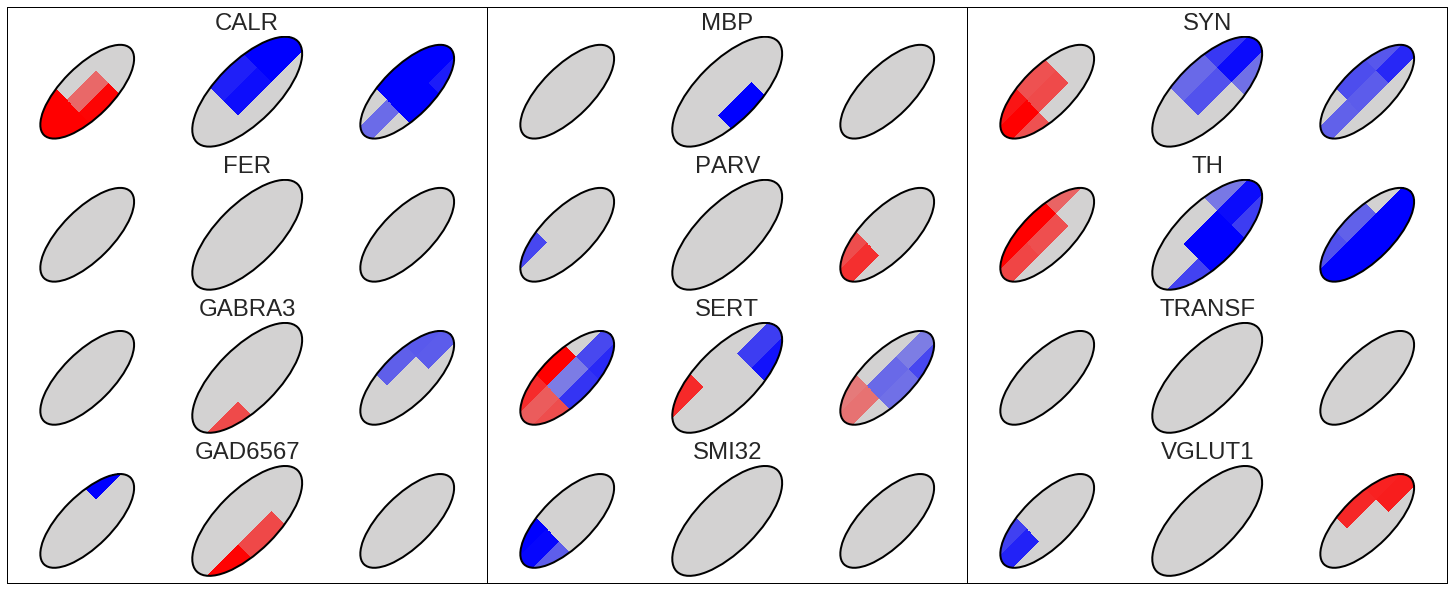

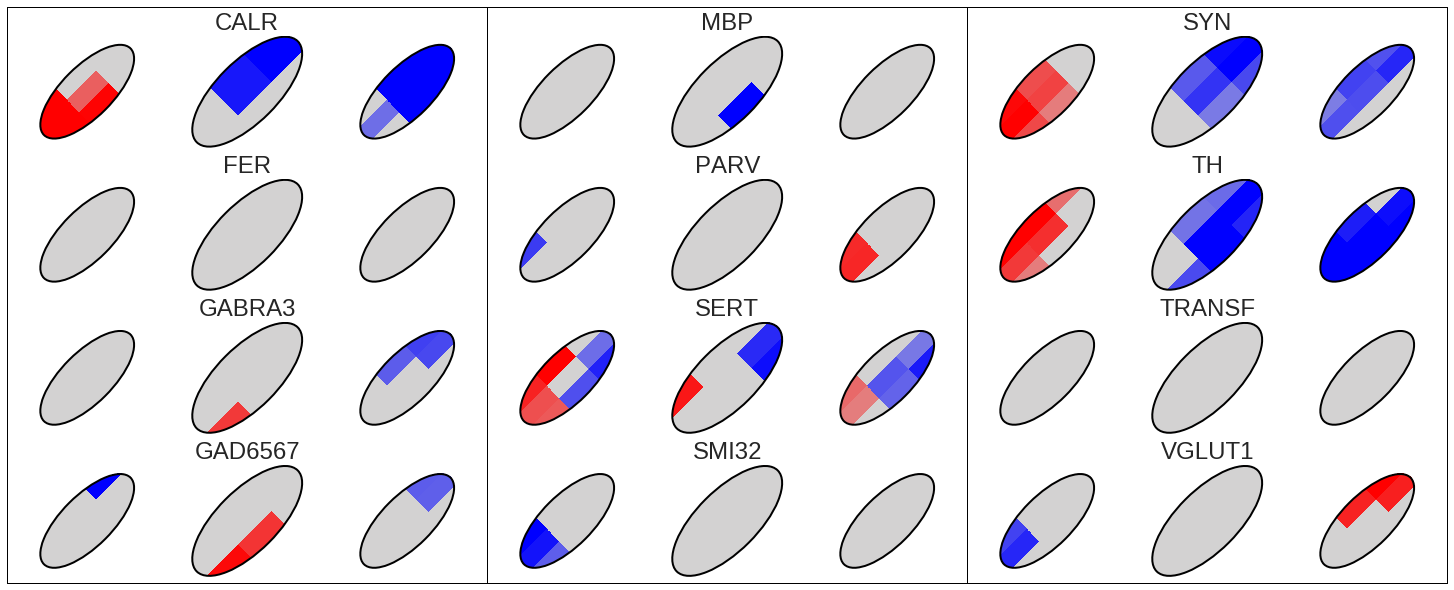

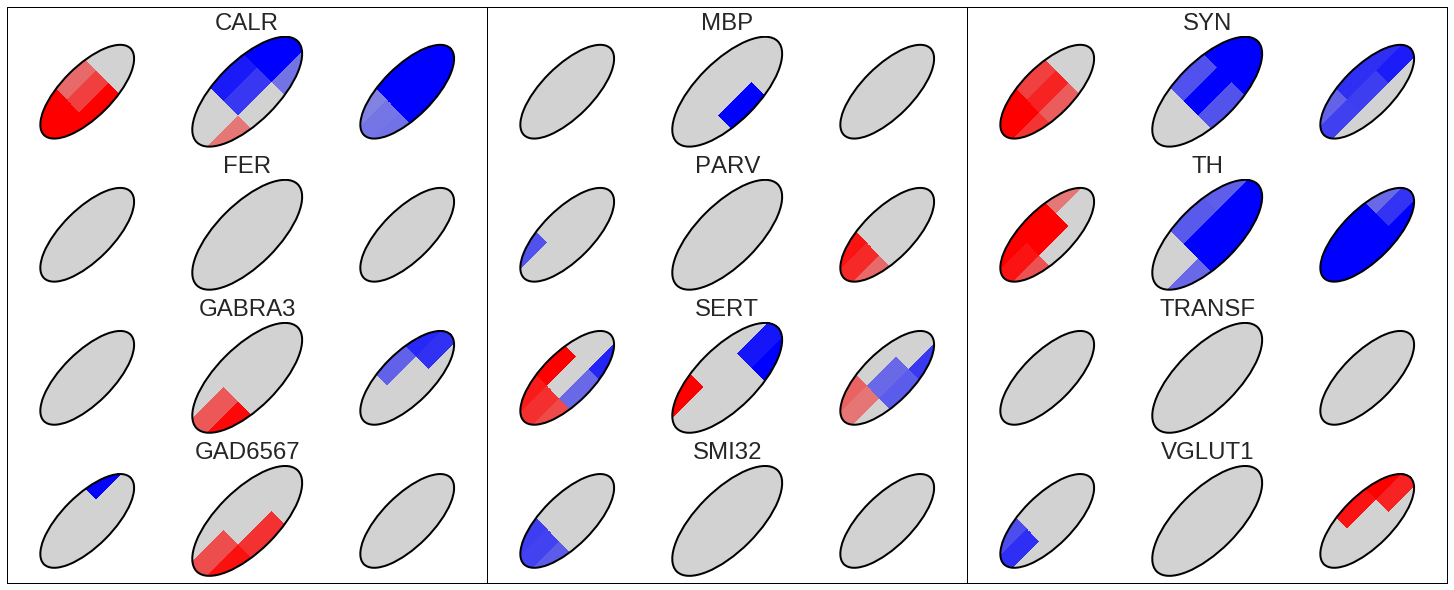

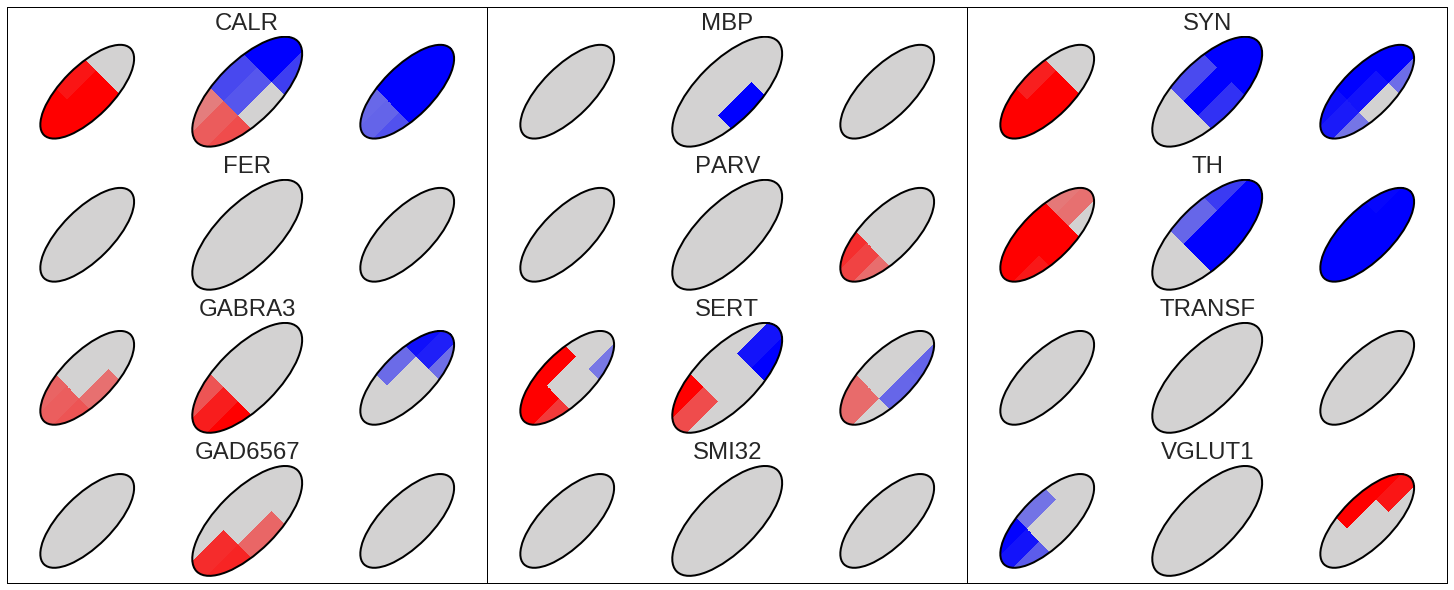

In [10]:
# Importing a number of different tools
import matplotlib
from statsmodels.sandbox.stats import multicomp
from matplotlib import patches
import scipy as sp
sns.set_style('white')
df.stain.unique()
%matplotlib inline

# gray 'background' of STN instead of white
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('colormap', ['blue', 'lightgray', 'red'])
def plot_ellipse_values(values, ellipse_pars=None, size=(1000, 1000), vmin=None, vmax=None, cmap=plt.cm.coolwarm, ax=None, **kwargs):

    ''' values is a n-by-m array'''

    values[np.isnan(values)] = 0
    if ellipse_pars is None:
        a = 350
        b = 150
        x = 500
        y = 500

        theta = 45. / 180 * np.pi

    else:
        a, b, x, y, theta = ellipse_pars

    A = a**2 * (np.sin(theta))**2 + b**2 * (np.cos(theta))**2
    B = 2 * (b**2 - a**2) * np.sin(theta) * np.cos(theta)
    C = a**2 * np.cos(theta)**2 + b**2 * np.sin(theta)**2
    D = -2 * A * x - B* y
    E = -B * x - 2 * C * y
    F = A* x**2 + B*x*y + C*y**2 - a**2*b**2

    X,Y = np.meshgrid(np.arange(size[0]), np.arange(size[1]))

    in_ellipse = A*X**2 + B*X*Y +C*Y**2 + D*X + E*Y +F < 0

    pc1 = np.array([[np.cos(theta)], [np.sin(theta)]])
    pc2 = np.array([[np.cos(theta - np.pi/2.)], [np.sin(theta - np.pi/2.)]])

    pc1_distance = pc1.T.dot(np.array([(X - x).ravel(), (Y - y).ravel()])).reshape(X.shape)
    pc2_distance = pc2.T.dot(np.array([(X - x).ravel(), (Y - y).ravel()])).reshape(X.shape)

    pc1_quantile = np.floor((pc1_distance / a + 1 ) / 2. * values.shape[0])
    pc2_quantile = np.floor((pc2_distance / b + 1 ) / 2. * values.shape[1])

    im = np.zeros_like(X, dtype=float)

    for pc1_q in np.arange(values.shape[0]):
        for pc2_q in np.arange(values.shape[1]):
            im[in_ellipse * (pc1_quantile == pc1_q) & (pc2_quantile == pc2_q)] = values[pc1_q, pc2_q]

    im = np.ma.masked_array(im, ~in_ellipse)
#     cmap.set_bad('grey')
    if ax is None:
        cax = plt.imshow(im, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax, **kwargs)
    else:
        ax.imshow(im, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax, **kwargs)
        cax = ax
#    sns.despine()

    return cax

fwhms = [0.3, 0.6, 1.2, 2.4]
for fwhm in fwhms:
    # What is the output folder for the PCA figures:
    pca_folder = '/home/mkeuken1/data/post_mortem/visualize_stains_v2/PCA_sectors/fwhm_%s' %fwhm
    if not os.path.exists(pca_folder):
        os.makedirs(pca_folder) 

    fig, axes = plt.subplots(nrows=4, ncols=3*3)
    
    # For every stain and sector over the 7 subjects plot the data and test whether it differs from zero:
    for ii, (stain, d) in enumerate(df.loc[df.fwhm==fwhm].groupby(['stain'])):
        fn = '/home/mkeuken1/data/post_mortem/visualize_stains_v2/PCA_sectors/fwhm_%s/combined_big_picture_coolwarm.pdf' %(fwhm)
        pdf = PdfPages(fn)
        column_set = int(np.floor(ii/4.))
        row_n = (ii)%4.

        for i, (slice, d2) in enumerate(d.groupby('slice_3')):
            print(row_n, ['anterior', 'middle', 'posterior'].index(slice) + 3*(column_set))
            ax = axes[row_n, ['anterior', 'middle', 'posterior'].index(slice) + 3*(column_set)]
#            ax = plt.subplot(1, 3, ['anterior', 'middle', 'posterior'].index(slice) + 1)

            n = d2.groupby(['pc1_3', 'pc2_3']).value.apply(lambda v: len(v)).unstack(1).ix[['ventral', 'middle', 'dorsal'], ['medial', 'middle', 'lateral']]
            t = d2.groupby(['pc1_3', 'pc2_3']).value.apply(lambda v: sp.stats.ttest_1samp(v, 0,nan_policy='omit')[0]).unstack(1).ix[['ventral', 'middle', 'dorsal'], ['medial', 'middle', 'lateral']]
            p = d2.groupby(['pc1_3', 'pc2_3']).value.apply(lambda v: sp.stats.ttest_1samp(v, 0,nan_policy='omit')[1]).unstack(1).ix[['ventral', 'middle', 'dorsal'], ['medial', 'middle', 'lateral']]
            mean = d2.groupby(['pc1_3', 'pc2_3']).value.mean().unstack(1).ix[['ventral', 'middle', 'dorsal'], ['medial', 'middle', 'lateral']]

            # FDR: as we are doing 27 seperate t-tests we need to correct for multiple comparisons:
            p.values[:] = multicomp.fdrcorrection0(p.values.ravel())[1].reshape(3, 3)

            # Providing some parameters for plotting the figures
            size_modulator = 10
            if i == 1:
                a, b, x, y, theta  = 350*size_modulator, 150*size_modulator, 300*size_modulator, 275*size_modulator, 45#*size_modulator
            else:
                a, b, x, y, theta  = 300*size_modulator, 125*size_modulator, 300*size_modulator, 275*size_modulator, 45.#*size_modulator

            plot_ellipse_values(t[p<0.05].values, size=(600*size_modulator, 550*size_modulator), ellipse_pars=(a, b, x, y,  theta / 180. * np.pi), vmin=-7, vmax=7, cmap=cmap, ax=ax)

            e1 = patches.Ellipse((x, y), a*2, b*2,
                                 angle=theta, linewidth=2, fill=False, zorder=2)

            ax.add_patch(e1)
            ax.set_xticks([])
            ax.set_yticks([])
            
            sns.despine(bottom=True, left=True, right=True)
            
            if slice == 'middle':
                ax.set_title(stain, fontsize=24)
            
            print stain
            print p.values

    fig.set_size_inches(10.*2, 4.*2)
    fig.subplots_adjust(hspace=.275, wspace=0.00, bottom=0.01, left=0.0, top=.95, right=1)
    
    plt.plot([0, 0], [0, 1], color='black', lw=1, transform=plt.gcf().transFigure, clip_on=False)
    plt.plot([0, 1], [1, 1], color='black', lw=1, transform=plt.gcf().transFigure, clip_on=False)
    plt.plot([1, 1], [0, 1], color='black', lw=1, transform=plt.gcf().transFigure, clip_on=False)
    plt.plot([0, 1], [0, 0], color='black', lw=1, transform=plt.gcf().transFigure, clip_on=False)

    plt.plot([1/3., 1/3.], [0, 1], color='black', lw=1, transform=plt.gcf().transFigure, clip_on=False)
    plt.plot([2/3., 2/3.], [0, 1], color='black', lw=1, transform=plt.gcf().transFigure, clip_on=False)
    fig.savefig(pdf,  format='pdf')#, bbox_inches='tight')
    pdf.close()

## Confetti

In [1]:
# Getting the mean rank number for the different cluster nubmers based on the AIC and BIC 
# Once we know for a given subject what the prefered number of mixtures is per stain we can plot it.

# Import several functions and set a few style features:
import os
import pandas as pd
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
# Select the smoothing kernel
fwhms = [0.3, 0.6, 1.2, 2.4]

for data_type in ['intensity', 'gradient_2D']:
    all_fwhms = []
    for fwhm in fwhms:
        # Read all the panda data that have 1-7 clusters
#        fns = glob.glob('/home/mkeuken1/data/post_mortem/ml_clusters_cross_validated_%s/pandas_%s/*_all.pandas' %(data_type, str(fwhm)))
        fns = glob.glob('/home/mkeuken1/data/post_mortem/ml_clusters_cross_validated_%s/*_%s_*_all.pandas' %(data_type, str(fwhm)))
        fns = [x for x in fns if int(os.path.basename(x).split('_')[3]) < 8]
        df = pd.concat([pd.read_pickle(fn) for fn in fns])

        # Select all rows (idx) to use for BIC/AIC model comparison
        idx_bicaic = df['train']=='All-Data-In-Mask'
        dfBICAIC = df[idx_bicaic].copy()

        # Calculate normalized aic and bic scores (for ranking)
        dfBICAIC['aic_rank'] = np.nan
        dfBICAIC['bic_rank'] = np.nan

        # Loop over all combinations of subject, stain, training set, plus metric (aic / bic) to calculate ranks
        tmp = dfBICAIC.drop('fwhm', axis=1).pivot_table(index=['subject_id','stain', 'train'], columns=['n_clusters'])
        for metric in ['aic', 'bic']:
            for subj in tmp[metric].reset_index()['subject_id'].unique():
                for stain in tmp[metric].reset_index()['stain'].unique():
                    for train in tmp[metric].reset_index()['train'].unique():
                        tmp[metric + '_rank'].loc[subj].loc[stain].loc[train] = tmp[metric].loc[subj].loc[stain].loc[train].rank()

        # Calculate mean rank per number of clusters based on AIC
        # Reset index and groupby subj id and stain to calculate mean rank per number of clusters (mean over training datasets, note that for 
        #   AIC and BIC we only have a single training set: 15% of the total data in STN mask.)
        tmp2 = tmp.reset_index().copy()
        tmp2 = tmp2.groupby(['subject_id', 'stain']).mean()['aic_rank']
        tmp2 = pd.melt(tmp2.reset_index(), id_vars=['subject_id', 'stain'], value_vars=[1,2,3,4,5,6], value_name='mean_rank')

        best_models_aic = tmp2.groupby(['subject_id', 'stain'])['mean_rank'].apply(lambda x: np.nanargmin(x)+1)
        best_models_aic = best_models_aic.reset_index(name='winning_model')

        # Calculate mean rank per number of clusters based on BIC
        # Reset index and groupby subj id and stain to calculate mean rank per number of clusters (mean over training datasets, note that for 
        #   AIC and BIC we only have a single training set: 15% of the total data in STN mask.
        tmp3 = tmp.reset_index().copy()
        tmp3 = tmp3.groupby(['subject_id', 'stain']).mean()['bic_rank']
        tmp3 = pd.melt(tmp3.reset_index(), id_vars=['subject_id', 'stain'], value_vars=[1,2,3,4,5,6], value_name='mean_rank')

        best_models_bic = tmp3.groupby(['subject_id', 'stain'])['mean_rank'].apply(lambda x: np.nanargmin(x)+1)
        best_models_bic = best_models_bic.reset_index(name='winning_model')

        # Creating extra dummy columns and concatenating both AIC and BIC in one df
        best_models_aic['metric'] = 'aic'
        best_models_bic['metric'] = 'bic'
        best_models = pd.concat([best_models_bic, best_models_aic])
        best_models['fwhm'] = fwhm
        all_fwhms.append(best_models)
    
    df_to_plot = pd.concat(all_fwhms)
    df_to_plot['subject_id'] = df_to_plot['subject_id'].apply(lambda x: str(x)[:2] + '-' + str(x)[2:])
    df_to_plot = df_to_plot.pivot_table(values='winning_model', index=['fwhm', 'stain'], columns=['metric', 'subject_id'])
    df_to_plot.to_excel('./confetti_excel_%s.xlsx' %data_type, )
#         # Lets now plot the winning cluster per stain per subject for both AIC and BIC seperately. 
#         loopdict = [{'name':'aic', 'df': best_models_aic}, {'name': 'bic', 'df': best_models_bic}]
#         for metric in loopdict:
#             fac = sns.swarmplot('stain', 'winning_model', 'subject_id', metric['df'], split=True, size=10, alpha=1, )
#             sns.despine()
#             fac.set_ylim((.5, 6.5))
#             ylims = fac.get_ylim()
#             xs = np.arange(0.5, 11.5, 1)
#             fac.vlines(x=xs, ymin=0, ymax=ylims[1], linewidths=1, linestyle='--', alpha=.5)
#             fac.set_ylabel('Number of clusters')

#             plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#             plt.gcf().set_size_inches(30, 6)
# #             f = plt.gcf()
# #             pdf = PdfPages('/home/mkeuken1/data/post_mortem/visualize_stains_v1/model_comparison_clusters/fwhm_%s/'%str(fwhm) + metric['name'] + '_' + data_type )
# #             f.savefig(pdf,  format='pdf', bbox_inches='tight')
# #             pdf.close()
# #             plt.close()
#        break
#    break

/opt/anaconda/anaconda2/lib/python2.7/site-packages/pandas/core/base.py:324: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  return self.obj.drop(self.exclusions, axis=1)


In [2]:
import os
import pandas as pd
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
df_to_plot = pd.read_pickle('./confetti_pickle_intensity.pkl')

In [4]:
# Set CSS properties for th elements in dataframe
th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', '#6d6d6d'),
  ('background-color', '#f7f7f9')
  ]

# Set CSS properties for td elements in dataframe
td_props = [
    ('font-size', '11px'),
    ('text-align', 'center')
  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

def background_gradient(s, m, M, cmap='PuBu', low=0, high=0):
    rng = M - m
    norm = colors.Normalize(m - (rng * low),
                            M + (rng * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

# df_to_plot.style.apply(background_gradient,
#                        cmap='PuBu',
#                        m=df_to_plot.min().min(),
#                        M=df_to_plot.max().max(),
#                        low=1,
#                        high=6).set_table_styles(styles).to_excel('./test.xlsx', engine='openpyxl')

In [9]:
writer = pd.ExcelWriter('./pandas_conditional.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
df_to_plot.to_excel(writer, sheet_name='Sheet1')

# Get the xlsxwriter workbook and worksheet objects.
workbook  = writer.book
worksheet = writer.sheets['Sheet1']

# Apply a conditional format to the cell range.
worksheet.conditional_format('B2:B8', {'type': '3_color_scale'})

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [ ]:
!ls

In [11]:
# Set colormap equal to seaborns light green color palette
cm = sns.light_palette("grey", as_cmap=True)

(df_to_plot.style
  .background_gradient(low=1, high=6)
  .set_table_styles(styles))

In [12]:
!ls /home/mkeuken1/data/post_mortem/ml_clusters_cross_validated_intensity/

13095_0.15_CALR_1_All-Data-In-Mask.pkl
13095_0.15_CALR_1_all.pandas
13095_0.15_CALR_1_CV_set1_1.pkl
13095_0.15_CALR_1_CV_set1_2.pkl
13095_0.15_CALR_1_CV_set2_1.pkl
13095_0.15_CALR_1_CV_set2_2.pkl
13095_0.15_CALR_1_CV_set3_1.pkl
13095_0.15_CALR_1_CV_set3_2.pkl
13095_0.15_CALR_2_All-Data-In-Mask.pkl
13095_0.15_CALR_2_all.pandas
13095_0.15_CALR_2_CV_set1_1.pkl
13095_0.15_CALR_2_CV_set1_2.pkl
13095_0.15_CALR_2_CV_set2_1.pkl
13095_0.15_CALR_2_CV_set2_2.pkl
13095_0.15_CALR_2_CV_set3_1.pkl
13095_0.15_CALR_2_CV_set3_2.pkl
13095_0.15_CALR_3_All-Data-In-Mask.pkl
13095_0.15_CALR_3_all.pandas
13095_0.15_CALR_3_CV_set1_1.pkl
13095_0.15_CALR_3_CV_set1_2.pkl
13095_0.15_CALR_3_CV_set2_1.pkl
13095_0.15_CALR_3_CV_set2_2.pkl
13095_0.15_CALR_3_CV_set3_1.pkl
13095_0.15_CALR_3_CV_set3_2.pkl
13095_0.15_CALR_4_All-Data-In-Mask.pkl
13095_0.15_CALR_4_all.pandas
13095_0.15_CALR_4_CV_set1_1.pkl
13095_0.15_CALR_4_CV_set1_2.pkl
13095_0.15_CALR_4_CV_set2_1.pkl
13095_0.15_CALR_4_CV_set2_2.pkl
13095_0.15_CALR_4_CV_set

## Kaarsjes

In [78]:
def exgauss_pdf(x, mu, sigma, nu):

    nu = 1./nu
    p1 = nu / 2. * np.exp((nu/2.)  * (2 * mu + nu * sigma**2. - 2. * x))
    p2 = sp.special.erfc((mu + nu * sigma**2 - x)/ (np.sqrt(2.) * sigma))

    return p1 * p2


In [79]:
class SimpleExgaussMixture(object):

    def __init__(self, data, n_clusters):

        self.data = data
        self.n_clusters = n_clusters
        self.n_parameters = n_clusters * 4 - 1
        self.likelihood = -np.inf

        self.previous_likelihoods = []
        self.previous_pars = []

    def get_likelihood_data(self, data):
        
        return mixed_exgauss_likelihood(data, self.w, self.mu, self.sigma, self.nu)
    
    def get_bic_data(self, data):
        likelihood = self.get_likelihood_data(data)
        return - 2 * likelihood + self.n_parameters * np.log(data.shape[0])
       
    def get_aic_data(self, data):
        likelihood = self.get_likelihood_data(data)
        return 2 * self.n_parameters - 2  * likelihood
    
    def _fit(self, **kwargs):
        return _fit((self.data, self.n_clusters), **kwargs)

    def fit(self, n_tries=1, **kwargs):
        for run in np.arange(n_tries):

            result = self._fit(**kwargs)
            self.previous_likelihoods.append(-result.fun)

            if -result.fun > self.likelihood:

                pars = result.x
                pars = np.insert(pars, self.n_clusters-1, 1 - np.sum(pars[:self.n_clusters-1]))

                self.w = pars[:self.n_clusters][np.newaxis, :]
                self.mu = pars[self.n_clusters:self.n_clusters*2][np.newaxis, :]
                self.nu = pars[self.n_clusters*2:self.n_clusters*3][np.newaxis, :]
                self.sigma = pars[self.n_clusters*3:self.n_clusters*4][np.newaxis, :]

                self.likelihood = -result.fun

        self.aic = 2 * self.n_parameters - 2 * self.likelihood
        self.bic = - 2 * self.likelihood + self.n_parameters * np.log(self.data.shape[0])

    def fit_multiproc(self, n_tries=4, n_proc=4, disp=False):

        pool = Pool(n_proc)

        print 'starting pool'
        results = pool.map(_fit, [(self.data, self.n_clusters)] * n_tries)
        print 'ready'

        print results

        pool.close()

        for result in results:
            self.previous_likelihoods.append(-result.fun)
            self.previous_pars.append(result.x)

            if -result.fun > self.likelihood:

                pars = result.x
                pars = np.insert(pars, self.n_clusters-1, 1 - np.sum(pars[:self.n_clusters-1]))

                self.w = pars[:self.n_clusters][np.newaxis, :]
                self.mu = pars[self.n_clusters:self.n_clusters*2][np.newaxis, :]
                self.nu = pars[self.n_clusters*2:self.n_clusters*3][np.newaxis, :]
                self.sigma = pars[self.n_clusters*3:self.n_clusters*4][np.newaxis, :]

                self.likelihood = -result.fun

        self.aic = 2 * self.n_parameters - 2 * self.likelihood
        self.bic = - 2 * self.likelihood + self.n_parameters * np.log(self.data.shape[0])

    def plot_fit(self):
        # Create indiviudal pds

        t = np.linspace(0, self.data.max(), 100)
        pdfs = self.w * exgauss_pdf(t[:, np.newaxis], self.mu, self.nu, self.sigma)

        sns.distplot(self.data)
        plt.plot(t, pdfs, c='k', alpha=0.5)

        plt.plot(t, np.sum(pdfs, 1), c='k', lw=2)

In [220]:
from sklearn.decomposition import PCA
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
sns.set_style('whitegrid')
import pandas
from pystain import StainDataset
import itertools
import cPickle as pkl

# Loading in the data
fwhms = [0.3, 0.6, 1.2, 2.4]
# Set the number of mixtures
ns = [1,2,3,4,5,6]
# Subject ids
subject_ids = [13095, 14037, 14051, 14069, 15033, 15035, 15055]
# Stains
stains = ['CALR', 'FER', 'GABRA3', 'GAD6567', 'MBP', 'PARV', 'SERT', 'SMI32', 'SYN', 'TH', 'TRANSF', 'VGLUT1']
# data type
data_types = ['intensity', 'gradient_2D']
print len(list(itertools.product(fwhms, ns, stains, subject_ids, data_types)))

df = pandas.DataFrame(columns=['data_type', 'test', 'train', 'subject_id', 'stain', 'fwhm', 'n_clusters', 'model'])
for subject_id in subject_ids:
    for data_type in data_types:
        for stain in stains:
            for n_clusters in ns:
                for fwhm in fwhms:
                    for cv_set in ['All-Data-In-Mask']:
                        fn = '/home/mkeuken1/data/post_mortem/ml_clusters_cross_validated_%s/%s_%s_%s_%s_%s.pkl' %(data_type, subject_id, fwhm, stain, n_clusters, cv_set)
                        print(fn)
                        with open(fn, 'r') as f:
                            model = pkl.load(f)
                        df_new_row = pandas.DataFrame({'subject_id': subject_id,
                                                  'fwhm': fwhm,
                                                  'train_set': cv_set,
                                                  'stain': stain,
                                                  'n_clusters': n_clusters,
                                                  'data_type': data_type,
                                                  'fit_object': model}, index=[0])
                        df = pandas.concat([df, df_new_row])

4032
/home/mkeuken1/data/post_mortem/ml_clusters_cross_validated_intensity/13095_0.3_CALR_1_All-Data-In-Mask.pkl
/home/mkeuken1/data/post_mortem/ml_clusters_cross_validated_intensity/13095_0.6_CALR_1_All-Data-In-Mask.pkl
/home/mkeuken1/data/post_mortem/ml_clusters_cross_validated_intensity/13095_1.2_CALR_1_All-Data-In-Mask.pkl
/home/mkeuken1/data/post_mortem/ml_clusters_cross_validated_intensity/13095_2.4_CALR_1_All-Data-In-Mask.pkl
/home/mkeuken1/data/post_mortem/ml_clusters_cross_validated_intensity/13095_0.3_CALR_2_All-Data-In-Mask.pkl
/home/mkeuken1/data/post_mortem/ml_clusters_cross_validated_intensity/13095_0.6_CALR_2_All-Data-In-Mask.pkl
/home/mkeuken1/data/post_mortem/ml_clusters_cross_validated_intensity/13095_1.2_CALR_2_All-Data-In-Mask.pkl
/home/mkeuken1/data/post_mortem/ml_clusters_cross_validated_intensity/13095_2.4_CALR_2_All-Data-In-Mask.pkl
/home/mkeuken1/data/post_mortem/ml_clusters_cross_validated_intensity/13095_0.3_CALR_3_All-Data-In-Mask.pkl
/home/mkeuken1/data/pos

In [221]:
import scipy as sp
def get_proportion_surely_one_cluster(row):
    
    fit_object = row.fit_object
    pdfs = fit_object.w * exgauss_pdf(fit_object.data[:, np.newaxis], fit_object.mu, fit_object.nu, fit_object.sigma)
    
    return ((pdfs.max(1) / pdfs.sum(1)) > 0.95).mean()

df['Proportion of strong cluster assignments'] = df.apply(get_proportion_surely_one_cluster, 1)
df['Number of clusters'] = df['n_clusters']

(0.0, 0.0)


/opt/anaconda/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/anaconda/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/anaconda/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/anaconda/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/anaconda/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/anaconda/anaconda2/lib/python2.7/si

(0.0, 1.0)
(0.0, 2.0)
(1.0, 0.0)
(1.0, 1.0)
(0.0, 0.0)
(0.0, 1.0)
(0.0, 2.0)
(1.0, 0.0)
(1.0, 1.0)
(0.0, 0.0)
(0.0, 1.0)
(0.0, 2.0)
(1.0, 0.0)
(1.0, 1.0)
(0.0, 0.0)
(0.0, 1.0)
(0.0, 2.0)
(1.0, 0.0)
(1.0, 1.0)
(0.0, 0.0)
(0.0, 1.0)
(0.0, 2.0)
(1.0, 0.0)
(1.0, 1.0)
(0.0, 0.0)
(0.0, 1.0)
(0.0, 2.0)
(1.0, 0.0)
(1.0, 1.0)
(0.0, 0.0)
(0.0, 1.0)
(0.0, 2.0)
(1.0, 0.0)
(1.0, 1.0)
(0.0, 0.0)
(0.0, 1.0)
(0.0, 2.0)
(1.0, 0.0)
(1.0, 1.0)


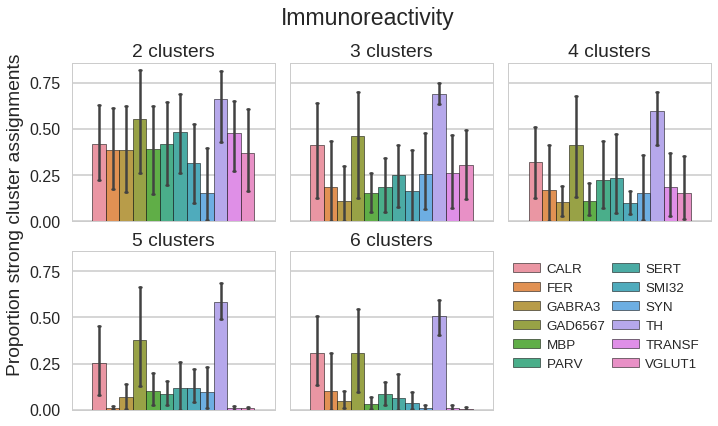

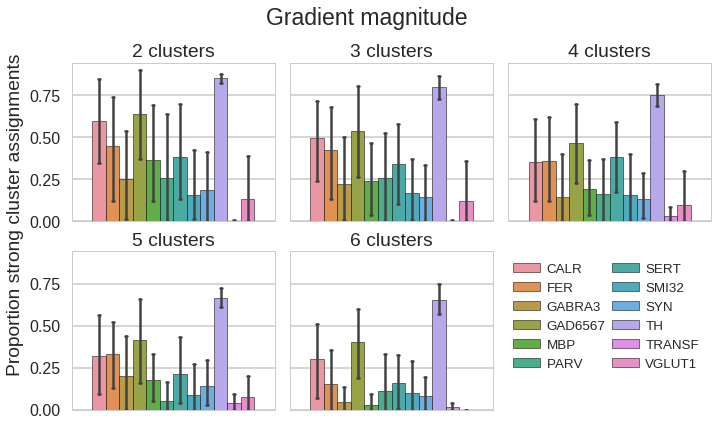

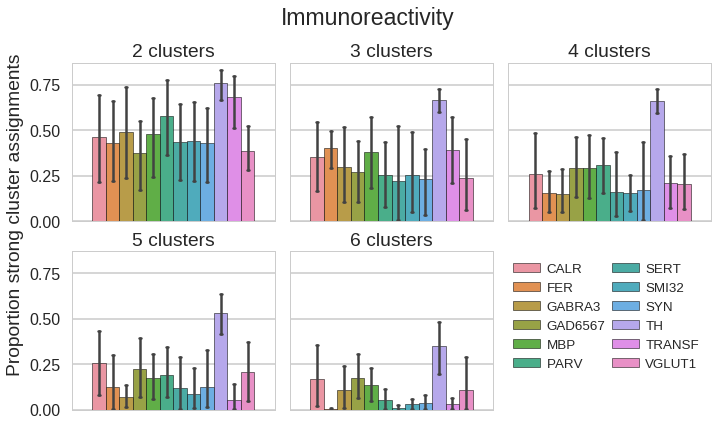

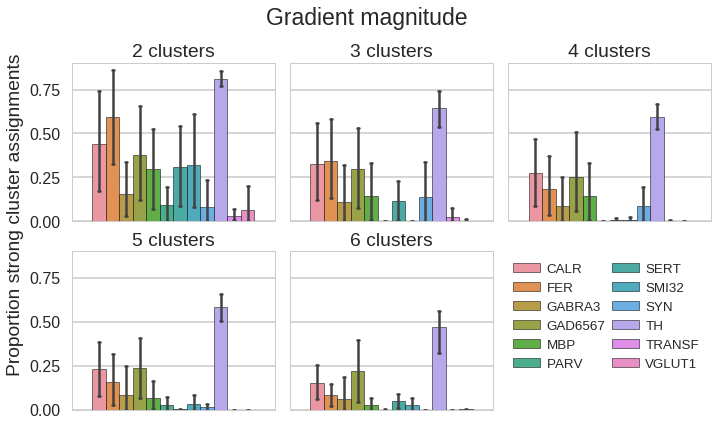

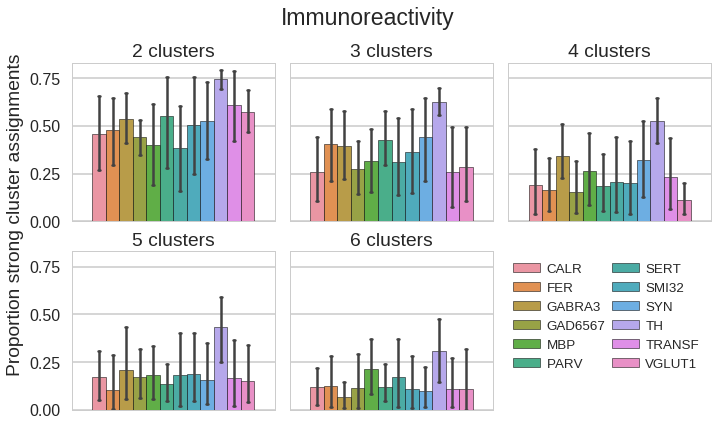

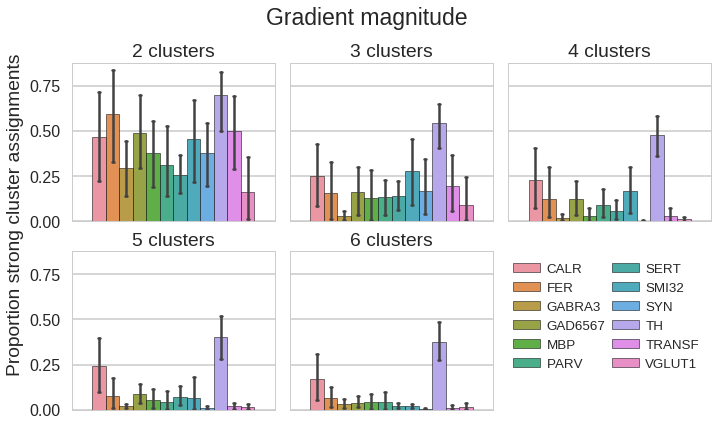

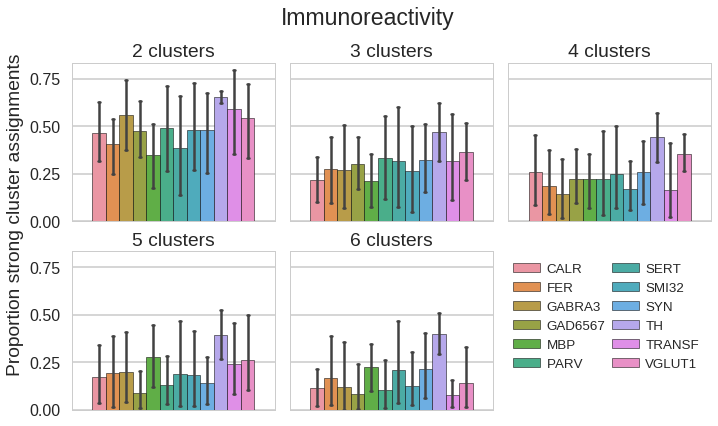

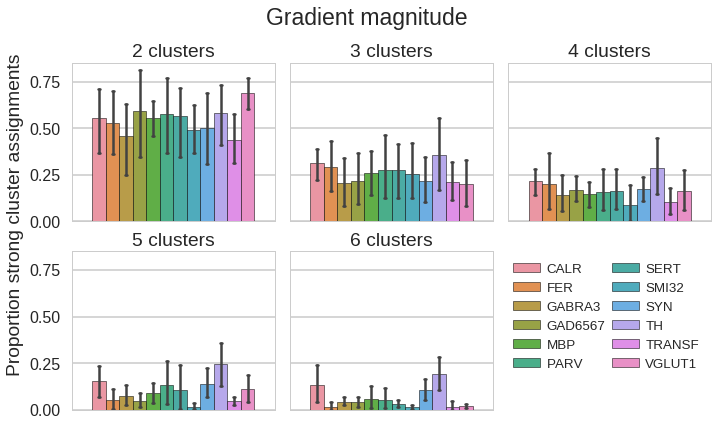

In [236]:
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_style('whitegrid')

#sns.palplot(sns.color_palette('Set3', 12))
for fwhm in fwhms:
    for data_type in data_types:
        df_data_type = df.loc[(df['data_type']==data_type) & (df['fwhm']==fwhm) & (df['n_clusters']>1)]
        tmp = df_data_type.groupby(['subject_id', 'Number of clusters', 'stain']).mean()
        tmp['dummy'] = 1
        tmp = tmp.reset_index()
        tmp['x'] = tmp['stain'].map(dict(zip(np.unique(tmp.stain), np.arange(len(np.unique(tmp.stain))))))
        tmp['Number of clusters'] = tmp['Number of clusters'].astype(int)

        f, ax = plt.subplots(2, 3, sharex=True, sharey=True)
        
        for i, n_cluster in enumerate(np.arange(2, 7)):
            row_n = np.floor(i/3.)
            col_n = i-row_n*3
            print(row_n, col_n)
            sns.barplot(x='dummy', y='Proportion of strong cluster assignments', hue='stain', 
                        data=tmp.loc[tmp['Number of clusters']==n_cluster], 
                        ax=ax[row_n, col_n], errwidth=2.5, capsize=0.01,
                        linewidth=.5, edgecolor="k")#, legend=False)
            
            ax[row_n, col_n].legend_.remove()
            ax[row_n, col_n].set_ylabel('')
            ax[row_n, col_n].set_xlabel('')
            ax[row_n, col_n].set_xticklabels([])
            ax[row_n, col_n].set_title('%d clusters' %n_cluster)
        ax[-1, -1].axis('off')
        ax[0, 2].legend(loc='center right', bbox_to_anchor=(1., -.60), ncol=2, 
                        columnspacing=.5, handletextpad=.5,
                        fontsize='x-small')

        suptxt = 'Gradient magnitude' if data_type=='gradient_2D' else 'Immunoreactivity'
        plt.tight_layout()
        plt.gcf().text(0.00, 0.5, 'Proportion strong cluster assignments', va='center', rotation='vertical')
        plt.gcf().suptitle(suptxt)
        plt.subplots_adjust(left=.09, top=.85)#, right=.95)

        plt.gcf().set_size_inches(10, 6)
        save_dir = '/home/mkeuken1/data/post_mortem/visualize_stains_v2/voxel_assignment'
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.savefig('/home/mkeuken1/data/post_mortem/visualize_stains_v2/voxel_assignment/voxel_assignments_%s_%s.pdf' %(data_type, str(fwhm)))